In [90]:
# IMPORTS #
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm
import tensorflow

/Users/pujan/VirtualEnvironments/hls4ml-Env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# CONSTANTS #

IMAGE_X = 300
IMAGE_Y = 300

GAUSSIAN_X = 48
GAUSSIAN_Y = 48

SCALE_FACTOR = 8

LABEL_X = IMAGE_X // SCALE_FACTOR
LABEL_Y = IMAGE_Y // SCALE_FACTOR

# Range for Random Gen
MIN_NUM_GAUSSIANS = 2
MAX_NUM_GAUSSIANS = 5

MIN_STD_X = 7
MAX_STD_X = 12

MIN_STD_Y = 7
MAX_STD_Y = 12

MIN_THETA = 0
MAX_THETA = np.pi

MIN_INTENSITY = 0.05
MAX_INTENSITY = 0.7


In [96]:
# Generate Gaussian Functions
def img_gen(VERBOSE: bool = False) -> tuple:

    img = np.zeros(shape=(IMAGE_Y, IMAGE_X))
    label = np.zeros(shape=(LABEL_Y, LABEL_X))
    params = []

    num_gaussians = np.random.randint(low=MIN_NUM_GAUSSIANS, high=MAX_NUM_GAUSSIANS)
    for gaussian in range(num_gaussians):

        # Randomize params
        center_x = np.random.randint(low=0 + GAUSSIAN_X // 2, high=IMAGE_X - GAUSSIAN_X // 2)
        center_y = np.random.randint(low=0 + GAUSSIAN_Y // 2, high=IMAGE_Y - GAUSSIAN_Y // 2)

        std_x = np.random.randint(low=MIN_STD_X, high=MAX_STD_X)
        std_y = np.random.randint(low=MIN_STD_Y, high=MAX_STD_Y)
        theta = np.random.randint(low=MIN_THETA, high=MAX_THETA)
        
        intensity = np.random.uniform(low=MIN_INTENSITY, high=MAX_INTENSITY)
        
        # Generate Gaussian
        params.append((center_x, center_y, std_x, std_y, theta, intensity))
        gaussian = gaussian_gen(center_x, center_y, std_x, std_y, theta)

        # Add Gaussian to img
        img += intensity * gaussian
        
        label_x = center_x // SCALE_FACTOR
        label_y = center_y // SCALE_FACTOR

        label[label_y, label_x] = 1

    # Convert to 8 bit int
    img = (img * 255).astype(np.uint8)

    # DEBUG
    if VERBOSE:
        # print(f"[Image Shape]: {str(img.shape)}")
        # print(f"[Label Shape]: {str(label.shape)}")
        print(f"[Target Gaussians #]: {str(num_gaussians)}")
        for param in params:
            print(
            f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
            f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
            f"[Theta]: {param[4]:.2f} "
            f"[I]: {param[5]:.2f} "
            )

    return (img, label, params)

def gaussian_gen(center_x: int, center_y: int, std_x: int, std_y: int, theta: float) -> np.ndarray:
    X = np.arange(0, IMAGE_X, 1)
    Y = np.arange(0, IMAGE_Y, 1)
    X, Y = np.meshgrid(X, Y)

    cos_theta_sqrd = np.pow(np.cos(theta),2)
    sin_theta_sqrd = np.pow(np.sin(theta),2)
    sin_cos_theta = np.sin(theta) * np.cos(theta)

    std_x_sqrd = np.pow(std_x, 2)
    std_y_sqrd = np.pow(std_y, 2)

    a = (cos_theta_sqrd) / (2 * std_x_sqrd) + (sin_theta_sqrd) / (2 * std_y_sqrd)
    b = -1 * (sin_cos_theta) / (2 * std_x_sqrd) + (sin_cos_theta) / (2 * std_y_sqrd)
    c = (sin_theta_sqrd) / (2 * std_x_sqrd) + (cos_theta_sqrd) / (2 * std_y_sqrd)

    gaussian = np.exp(-(a * (X - center_x)**2 + 2*b * (X - center_x) * (Y - center_y) + c * (Y - center_y)**2))

    return gaussian

def img_shift():
    pass

def img_scale():
    pass

def img_visualization_one(img: np.ndarray, label: np.ndarray, params: list) -> None:
    rgb_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Coords of Gaussians:
    for x in range(LABEL_X):
        for y in range(LABEL_Y):
            if label[y, x] == 1:
                
                top_left = (x * SCALE_FACTOR - GAUSSIAN_X // 2, y * SCALE_FACTOR - GAUSSIAN_Y // 2)
                bottom_right = (x * SCALE_FACTOR + GAUSSIAN_X // 2, y * SCALE_FACTOR + GAUSSIAN_Y // 2)
                color = (0, 200, 200)
                thickness = 2
                
                cv2.rectangle(rgb_image, top_left, bottom_right, color, thickness)

    for param in params:
        print(
        f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
        f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
        f"[Theta]: {param[4]:.2f} "
        f"[I]: {param[5]:.2f} "
        )
    
    plt.imshow(rgb_image)



def img_visualization_two(img: np.ndarray, label: np.ndarray, params: list) -> None:
    
    for param in params:
        print(
        f"[(c_x, c_y)]: ({param[0]:<3}, {param[1]:<3}) "
        f"[(s_x, s_y)]: ({param[2]:<3}, {param[3]:<3}) "
        f"[Theta]: {param[4]:.2f} "
        f"[I]: {param[5]:.2f} "
        )

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')


[(c_x, c_y)]: (71 , 74 ) [(s_x, s_y)]: (8  , 9  ) [Theta]: 1.00 [I]: 0.20 
[(c_x, c_y)]: (107, 246) [(s_x, s_y)]: (10 , 11 ) [Theta]: 1.00 [I]: 0.25 
[(c_x, c_y)]: (43 , 193) [(s_x, s_y)]: (11 , 9  ) [Theta]: 2.00 [I]: 0.46 
[(c_x, c_y)]: (275, 122) [(s_x, s_y)]: (11 , 7  ) [Theta]: 2.00 [I]: 0.68 


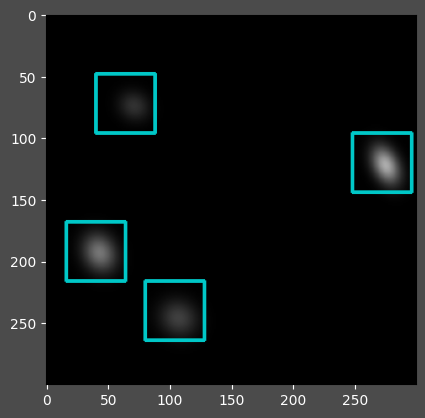

In [97]:
# Generate Training Data
img, label, params = img_gen(VERBOSE=False)
img_visualization_one(img, label, params)

In [ ]:
# Normalize: 


In [ ]:
# Model Architecture